# MLOps Exercise: Medical Image Classification with Chest X-Ray Images

## Introduction

In this exercise, you'll gain practical experience with MLOps (Machine Learning Operations) by working on a real-world problem: classifying chest X-ray images to diagnose pneumonia. You'll go through various stages, from data cleaning to deployment, learning how to manage an end-to-end machine learning pipeline.

### Prerequisites

- Basic understanding of Python
- Familiarity with machine learning concepts
- Experience with Jupyter Notebooks

### Tools and Libraries

- Python
- NumPy
- OpenCV
- TensorFlow/Keras
- scikit-learn
- Flask
- Matplotlib
- imbalanced-learn

These libraries should cover most requirements for this exercise, including data manipulation (NumPy, pandas), visualization (Matplotlib), machine learning (scikit-learn, TensorFlow), image processing (OpenCV), and class imbalance treatment (imbalanced-learn).

### Table of Contents

1. [Data Loading and Cleaning](#Data-Loading-and-Cleaning)
2. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
3. [Class Imbalance](#Class-Imbalance)
4. [Model Building](#Model-Building)
5. [Data Augmentation](#Data-Augmentation)
6. [Model Evaluation](#Model-Evaluation)
7. [Model Deployment (Bonus)](#Model-Deployment-(Bonus))


## Environment Setup

Before we begin, let's set up the environment. We'll install the necessary Python packages for this exercise.

```bash
pip install numpy pandas opencv-python matplotlib scikit-learn tensorflow flask
```

You can also create a `requirements.txt` file with the above packages and install them using `pip install -r requirements.txt`.
Be aware that you should download ipykernel and export your env to the jupyter notebook.
```bash
python -m ipykernel install --user --name=my_new_env
```

## Data Loading and Cleaning

### Objective

Load the dataset and clean it by removing corrupted images.

### Guidance

1. Download the Chest X-Ray Images (Pneumonia) dataset and place it in a directory accessible by this notebook. From https://ametice.univ-amu.fr
2. Unzip the dataset and explore its directory structure.
3. Load the images and labels for training.
4. Write a function to scan for and remove any corrupted or invalid images.

### Exercise

Now, load the dataset use the zipfile library and clean it by removing corrupted images. Write your code in the cell below.

```python
import zipfile

zip_file_path = 'path/to/your/zip/file.zip'
extract_path = 'path/to/extract/folder'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
```

After extracting, your dataset should have the following folder structure:

```
/
|-- test/
|   |-- NORMAL/
|   |-- PNEUMONIA/
|-- train/
|   |-- NORMAL/
|   |-- PNEUMONIA/
|-- val/
    |-- NORMAL/
    |-- PNEUMONIA/
```

You can point `train_path` and `test_path` to the `train` and `test` folders inside this extracted directory

In [2]:
import os
from PIL import Image
import numpy as np

# train path and test path
train_path = '../data/raw/chest_xray/train'
test_path = '../data/raw/chest_xray/test'
val_path = '../data/raw/chest_xray/val'


def load_images(folder_path):
    images = []
    labels = []
    class_labels = {"NORMAL": 0, "PNEUMONIA": 1}
    
    for folder in os.listdir(folder_path):
        img_folder = os.path.join(folder_path, folder)
        label = class_labels[folder]
        for img_file in os.listdir(img_folder):
            img_path = os.path.join(img_folder, img_file)
            # load image if not corrupted
            try:
                img = Image.open(img_path)
                # resize image
                img = img.resize((128, 128))
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}")

    
    return images, labels

# load valide images from the dataset
train_images, train_labels = load_images(train_path)
test_images, test_labels = load_images(test_path)
val_images, val_labels = load_images(val_path)

In [3]:
# verify that images had been loaded
print("Train : ", len(train_images), " images")
print("Test : ", len(test_images), " images")
print("Val : ", len(val_images), " images")

Train :  5216  images
Test :  624  images
Val :  16  images


## Exploratory Data Analysis (EDA)

### Objective

Understand the dataset's basic statistics and visualize the data.

### Guidance

1. Use matplotlib to visualize some sample images from each class.
2. Investigate the distribution of classes (Pneumonia/Normal).

### Exercise

Perform exploratory data analysis on the dataset. Write your code in the cell below.


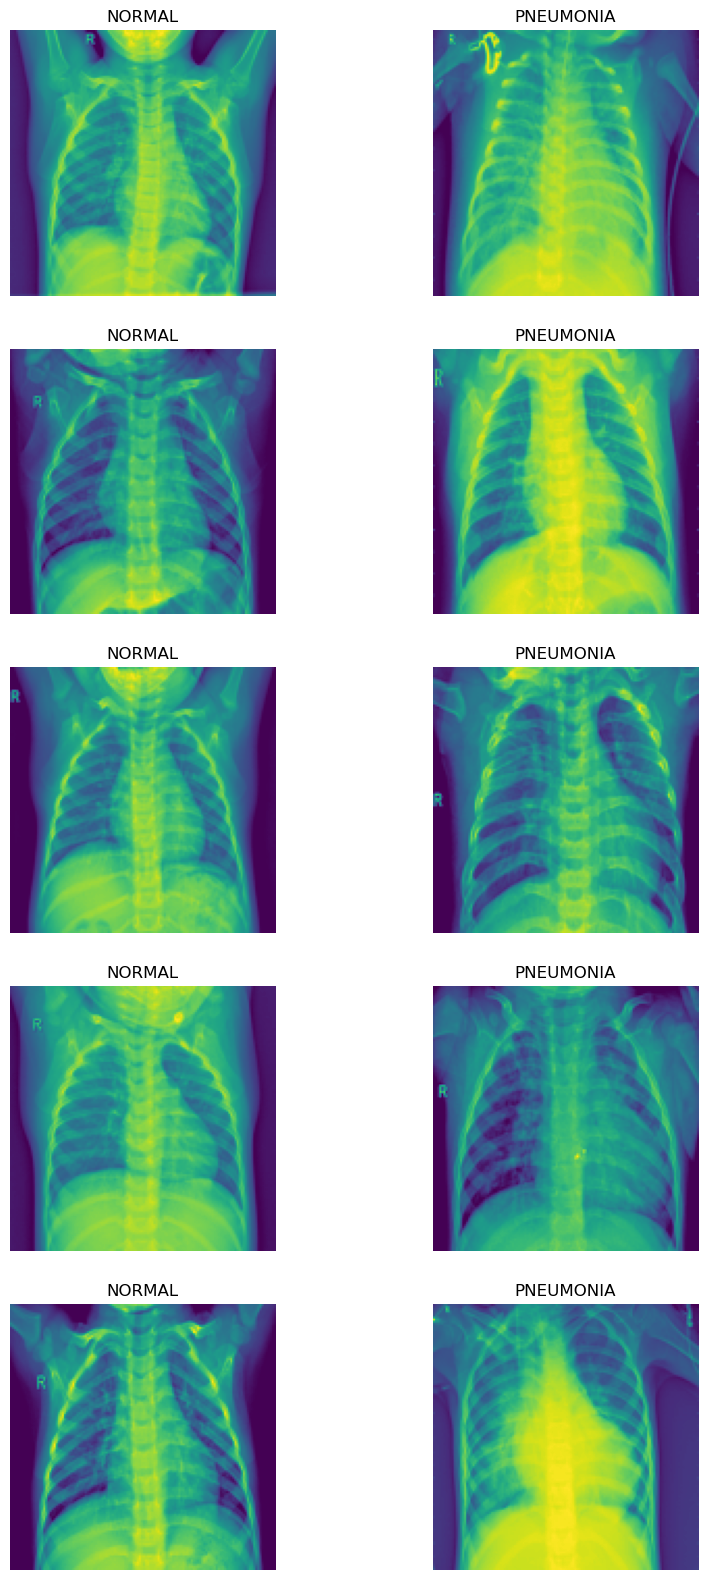

In [4]:
import matplotlib.pyplot as plt

nb_samples = 5
normal_samples = []
pneumonia_samples = []

i = 0
while len(normal_samples) < nb_samples:
    if(train_labels[i] == 0) : normal_samples.append(train_images[i])
    i+=1   

i = 0
while len(pneumonia_samples) < nb_samples:
    if(train_labels[i] == 1) : pneumonia_samples.append(train_images[i])
    i+=1

fig, axes = plt.subplots(nb_samples, 2, figsize=(10, 20))

for i in range(nb_samples):
    axes[i][0].imshow(normal_samples[i])
    axes[i][0].set_title("NORMAL")
    axes[i][0].axis('off')
    axes[i][1].imshow(pneumonia_samples[i])
    axes[i][1].set_title("PNEUMONIA")
    axes[i][1].axis('off')

plt.show()    

1341 3875


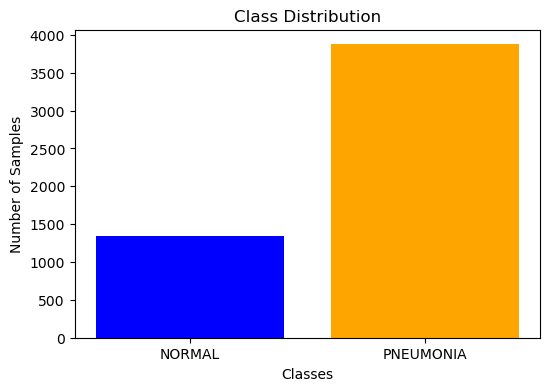

In [5]:
# count the number of images for each class
nb_normal = sum(1 for label in train_labels if label == 0)
nb_pneumonia = sum(1 for label in train_labels if label == 1)

print(nb_normal, nb_pneumonia)

# visualize the distribution of classes (Pneumonia/Normal)
plt.figure(figsize=(6, 4))
plt.bar(["NORMAL", "PNEUMONIA"], [nb_normal, nb_pneumonia], color=['blue', 'orange'])
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

## Class Imbalance

### Objective

Understand how class imbalance affects model performance and learn ways to mitigate it.

### Guidance

1. Train a baseline model without accounting for class imbalance.
2. Evaluate its performance using metrics like accuracy, precision, recall, and F1-score.
3. Experiment with techniques like class weighting or oversampling methods like SMOTE to balance the classes.

### Exercise

Address the class imbalance and evaluate the impact on the model. Write your code in the cell below.


In [6]:
train = np.empty((5216, 128, 128))

for i, image in enumerate(train_images):
    l = [value / 255.0 for value in image.convert('L').getdata()]
    for j in range (128):
        for k in range (128):
            train[i][j][k] = l[j*128+k]

train_labels = np.array(train_labels)

In [7]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.fit(train, train_labels, epochs=10, batch_size=32)


Epoch 1/10
163/163 [==============================] - 97s 556ms/step - loss: 0.2469 - accuracy: 0.8947
Epoch 2/10
163/163 [==============================] - 95s 583ms/step - loss: 0.1134 - accuracy: 0.9586
Epoch 3/10
163/163 [==============================] - 94s 579ms/step - loss: 0.0791 - accuracy: 0.9686
Epoch 4/10
163/163 [==============================] - 93s 570ms/step - loss: 0.0781 - accuracy: 0.9714
Epoch 5/10
163/163 [==============================] - 95s 585ms/step - loss: 0.0671 - accuracy: 0.9743
Epoch 6/10
163/163 [==============================] - 96s 589ms/step - loss: 0.0585 - accuracy: 0.9772
Epoch 7/10
163/163 [==============================] - 96s 592ms/step - loss: 0.0412 - accuracy: 0.9837
Epoch 8/10
163/163 [==============================] - 96s 591ms/step - loss: 0.0330 - accuracy: 0.9889
Epoch 9/10
163/163 [==============================] - 98s 603ms/step - loss: 0.0312 - accuracy: 0.9873
Epoch 10/10
163/163 [==============================] - 104s 640ms/step - 

In [12]:
model.save("../models/pneumonia_basic.h5")

In [8]:
from sklearn.metrics import precision_recall_fscore_support

test = np.empty((624, 128, 128))

for i, image in enumerate(test_images):
    l = [value / 255.0 for value in image.convert('L').getdata()]
    for j in range (128):
        for k in range (128):
            test[i][j][k] = l[j*128+k]

test_labels = np.array(test_labels)

predictions = model.predict(test)

threshold = 0.5
predicted_classes = (predictions > threshold).astype(int)

precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, predicted_classes, average=None)

for i in range(len(precision)):
    print(f"Classe {i}:")
    print(f"Précision: {precision[i]}")
    print(f"Rappel: {recall[i]}")
    print(f"F1-score: {f1_score[i]}")
    print("----")

average_precision = precision.mean()
average_recall = recall.mean()
average_f1_score = f1_score.mean()

print(f"Précision moyenne: {average_precision}")
print(f"Rappel moyen: {average_recall}")
print(f"F1-score moyen: {average_f1_score}")


20/20 [==============================] - 3s 143ms/step
Classe 0:
Précision: 0.9809523809523809
Rappel: 0.44017094017094016
F1-score: 0.6076696165191741
----
Classe 1:
Précision: 0.7475915221579962
Rappel: 0.9948717948717949
F1-score: 0.8536853685368537
----
Précision moyenne: 0.8642719515551885
Rappel moyen: 0.7175213675213675
F1-score moyen: 0.730677492528014


## Model Building

### Objective

Build and train a deep learning model for image classification.

### Guidance

1. Use a Convolutional Neural Network (CNN) for this task.
2. Experiment with different architectures and hyperparameters.

### Exercise

Build and train your model. Write your code in the cell below.


In [9]:
train_2 = train[:2682]
train_labels_2 = train_labels[:2682]

In [10]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model1.fit(train_2, train_labels_2, epochs=10, batch_size=32)

Epoch 1/10
84/84 [==============================] - 54s 615ms/step - loss: 0.3289 - accuracy: 0.8341
Epoch 2/10
84/84 [==============================] - 50s 590ms/step - loss: 0.1558 - accuracy: 0.9463
Epoch 3/10
84/84 [==============================] - 49s 585ms/step - loss: 0.1060 - accuracy: 0.9638
Epoch 4/10
84/84 [==============================] - 51s 602ms/step - loss: 0.0697 - accuracy: 0.9754
Epoch 5/10
84/84 [==============================] - 50s 597ms/step - loss: 0.0745 - accuracy: 0.9691
Epoch 6/10
84/84 [==============================] - 51s 602ms/step - loss: 0.0831 - accuracy: 0.9709
Epoch 7/10
84/84 [==============================] - 50s 593ms/step - loss: 0.0601 - accuracy: 0.9761
Epoch 8/10
84/84 [==============================] - 50s 594ms/step - loss: 0.0430 - accuracy: 0.9855
Epoch 9/10
84/84 [==============================] - 50s 595ms/step - loss: 0.0315 - accuracy: 0.9884
Epoch 10/10
84/84 [==============================] - 50s 595ms/step - loss: 0.0313 - accura

In [13]:
model.save("../models/pneumonia_under_sampling.h5")

In [11]:
from sklearn.metrics import precision_recall_fscore_support

test = np.empty((624, 128, 128))

for i, image in enumerate(test_images):
    l = [value / 255.0 for value in image.convert('L').getdata()]
    for j in range (128):
        for k in range (128):
            test[i][j][k] = l[j*128+k]

test_labels = np.array(test_labels)

predictions = model1.predict(test)

threshold = 0.5
predicted_classes = (predictions > threshold).astype(int)

precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, predicted_classes, average=None)

for i in range(len(precision)):
    print(f"Classe {i}:")
    print(f"Précision: {precision[i]}")
    print(f"Rappel: {recall[i]}")
    print(f"F1-score: {f1_score[i]}")
    print("----")

average_precision = precision.mean()
average_recall = recall.mean()
average_f1_score = f1_score.mean()

print(f"Précision moyenne: {average_precision}")
print(f"Rappel moyen: {average_recall}")
print(f"F1-score moyen: {average_f1_score}")


20/20 [==============================] - 3s 157ms/step
Classe 0:
Précision: 0.9779411764705882
Rappel: 0.5683760683760684
F1-score: 0.7189189189189189
----
Classe 1:
Précision: 0.7930327868852459
Rappel: 0.9923076923076923
F1-score: 0.8815489749430524
----
Précision moyenne: 0.8854869816779171
Rappel moyen: 0.7803418803418803
F1-score moyen: 0.8002339469309856


## Data Augmentation

### Objective

Improve your model's performance by using data augmentation techniques.

### Guidance

1. Apply data augmentation techniques like rotation, flipping, and zooming to generate more training data.
2. Retrain your model using the augmented dataset.

### Exercise

Apply data augmentation techniques and evaluate the impact on the model. Write your code in the cell below.


In [40]:

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def visualize_samples(images, nb_samples):
    normal_samples = images[:nb_samples]

    fig, axes = plt.subplots(nb_samples, 1, figsize=(10, 20))

    for i in range(nb_samples):
        axes[i].imshow(normal_samples[i])
        axes[i].set_title("NORMAL")
        axes[i].axis('off')

    plt.show() 

normal_images = train[:1321]

datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

generated_images = []

for i in normal_images:
    image =  image.reshape(1, 128, 128, 1) 
    for generated_image in datagen.flow(image, batch_size=1):
        generated_image = np.squeeze(generated_image, axis=0)
        generated_images.append(generated_image.reshape(128, 128))
        break

# visualize_samples(generated_images, 10)

train_3 = np.concatenate((train, np.array(generated_images)))
train_labels_3 = np.concatenate((train_labels, np.zeros(len(generated_images))))



In [41]:
import sys
sys.path.append('../scripts/')
from train import train_cnn

train_cnn(train_3, train_labels_3, "../models/pneumonia_over_sampling.h5")

Epoch 1/10
205/205 [==============================] - 157s 714ms/step - loss: 0.2523 - accuracy: 0.8825
Epoch 2/10
205/205 [==============================] - 141s 686ms/step - loss: 0.1017 - accuracy: 0.9610
Epoch 3/10
205/205 [==============================] - 141s 689ms/step - loss: 0.0796 - accuracy: 0.9702
Epoch 4/10
205/205 [==============================] - 141s 686ms/step - loss: 0.0681 - accuracy: 0.9740
Epoch 5/10
205/205 [==============================] - 167s 813ms/step - loss: 0.0533 - accuracy: 0.9806
Epoch 6/10
205/205 [==============================] - 159s 776ms/step - loss: 0.0486 - accuracy: 0.9816
Epoch 7/10
205/205 [==============================] - 165s 806ms/step - loss: 0.0364 - accuracy: 0.9879
Epoch 8/10
205/205 [==============================] - 138s 675ms/step - loss: 0.0383 - accuracy: 0.9858
Epoch 9/10
205/205 [==============================] - 141s 690ms/step - loss: 0.0345 - accuracy: 0.9865
Epoch 10/10
205/205 [==============================] - 139s 679m

## Model Evaluation

### Objective

Evaluate your model's performance using different metrics and visualization tools.

### Guidance

1. Use metrics like accuracy, precision, recall, and F1-score for evaluation.
2. Plot confusion matrices and ROC curves to visualize your model's performance.

### Exercise

Evaluate your model and interpret the results. Write your code in the cell below.


In [43]:
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.models import load_model

test = np.empty((624, 128, 128))

for i, image in enumerate(test_images):
    l = [value / 255.0 for value in image.convert('L').getdata()]
    for j in range (128):
        for k in range (128):
            test[i][j][k] = l[j*128+k]

test_labels = np.array(test_labels)

model2 = model = load_model("../models/pneumonia_over_sampling.h5")

predictions = model2.predict(test)

threshold = 0.5
predicted_classes = (predictions > threshold).astype(int)

precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, predicted_classes, average=None)

for i in range(len(precision)):
    print(f"Classe {i}:")
    print(f"Précision: {precision[i]}")
    print(f"Rappel: {recall[i]}")
    print(f"F1-score: {f1_score[i]}")
    print("----")

average_precision = precision.mean()
average_recall = recall.mean()
average_f1_score = f1_score.mean()

print(f"Précision moyenne: {average_precision}")
print(f"Rappel moyen: {average_recall}")
print(f"F1-score moyen: {average_f1_score}")

20/20 [==============================] - 5s 224ms/step
Classe 0:
Précision: 0.9868421052631579
Rappel: 0.32051282051282054
F1-score: 0.48387096774193544
----
Classe 1:
Précision: 0.7098540145985401
Rappel: 0.9974358974358974
F1-score: 0.8294243070362474
----
Précision moyenne: 0.848348059930849
Rappel moyen: 0.658974358974359
F1-score moyen: 0.6566476373890914


## Model Deployment (Bonus)

### Objective

Learn the basics of deploying a machine learning model.

### Guidance

1. Save your trained model.
2. Use Flask to create a simple REST API to serve your model.

### Exercise

Deploy your model using Flask. Write your code in the cell below.


In [ ]:

# Your code here for Model Deployment (Bonus)



### Next Steps

1. Experiment with more advanced architectures and hyperparameters.
2. Deploy your model
3. Integrate your model into a web application or other services.
4. Learn more about MLOps best practices and tools.


